In [15]:
import torch
import torch.nn as nn

class BIM():
    def __init__(self , epsilon, alpha, num_iterations):
        """
        Basic Iterative Method (BIM) for generating adversarial examples.

        Args:
            epsilon (float): Maximum allowed perturbation.
            alpha (float): Step size for each iteration.
            num_iterations (int): Number of iterations to perform.
        """
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_iterations = num_iterations
    def attack(self , model , image , label):
        """
        Generates an adversarial example using BIM.

        Args:
            model (nn.Module): Target model to attack.
            image (torch.Tensor): Input image tensor.
            label (torch.Tensor): True label tensor for the input image.

        Returns:
            torch.Tensor: Adversarial example tensor.
        """
        # Clone the input images to avoid modifying the original data
        perturbed_image = image.clone().detach()
        perturbed_image.requires_grad = True
        model = model.classify_model

        for _ in range(self.num_iterations):
            # Zero the gradients
            model.zero_grad()

            # Forward pass
            output = model(perturbed_image)

            # Compute the loss
            loss = nn.CrossEntropyLoss()(output, label)

            # Backward pass to compute gradients
            loss.backward()

            # Perform a step similar to FGSM
            grad_sign = perturbed_image.grad.data.sign()
            perturbed_image = perturbed_image + self.alpha * grad_sign

            # Clip the adversarial image to maintain the epsilon constraint [x - epsilon , x + epsilon] L infinty norm
            perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)

            # Clamp to ensure pixel values are within the valid range [0, 1]
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            # Detach gradients to avoid accumulation
            perturbed_image = perturbed_image.clone().detach()
            perturbed_image.requires_grad = True

        return perturbed_image

In [2]:
import torch
import torch.nn as nn
class FGSM:
    def __init__(self , epsilon , targeted = False):
        """
        Fast Gradient Sign Method(FGSM) for generating adversarial examples.

        Args:
            epsilon (float): Maximum allowed perturbation.
            targeted (bool): Specifiy if the attack is targeted or not.
        """
        self.epsilon = epsilon
        self.targeted = targeted
    def attack(self , model , image , label):
        """
        Generates an adversarial example using

        Args:
            model (nn.Module): Target model to attack.
            image (torch.Tensor): Input image tensor.
            label (torch.Tensor): is the true label in the case of untargeted attack and the target label in the case of targeted attacks
        """
        image.requires_grad = True
        model = model.classify_model
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, label)
        model.zero_grad()
        loss.backward()  # Compute gradients with respect to input images
        grad_sign = image.grad.data.sign()
        if (self.targeted):
            perturbed_image = image - self.epsilon * grad_sign # Apply targeted attack

        else:
            perturbed_image = image + self.epsilon * grad_sign  # Apply untargeted attack

        # Clip to ensure valid pixel range (0-1 for normalized images)
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        return perturbed_image


In [19]:
import torch
import torch.nn as nn

class PGD:
    def __init__(self, epsilon, alpha, num_iterations):
        """
        Projected Gradient Descent (PGD) for generating adversarial examples.

        Args:
            epsilon (float): Maximum allowed perturbation.
            alpha (float): Step size for each attack iteration.
            steps (int): Number of attack steps.
        """
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_iterations = num_iterations

    def attack(self, model, image, label):
        """
        Generates adversarial examples using PGD.

        Args:
            model (nn.Module): Target model to attack.
            image (torch.Tensor): Input image tensor.
            label (torch.Tensor): True label (for untargeted attack) or target label (for targeted attack).

        Returns:
            torch.Tensor: Adversarial image.
        """
        # Clone the input image to create adversarial examples
        perturbed_image = image.clone().detach()
        model = model.classify_model

        # random initialization
        perturbed_image += torch.empty_like(image).uniform_(-self.epsilon, self.epsilon)
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        for _ in range(self.num_iterations):
            # Enable gradient computation for the perturbed image
            perturbed_image.requires_grad = True
            output = model(perturbed_image)

            # Compute the loss
            loss = nn.CrossEntropyLoss()(output, label)


            # Compute gradients with respect to the input
            model.zero_grad()
            loss.backward()
            grad_sign = perturbed_image.grad.data.sign()

            # Update the adversarial image
            perturbed_image = perturbed_image + self.alpha * grad_sign
            perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1).detach()  # Ensure valid pixel range and detach gradients

        return perturbed_image


In [13]:
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

import torch
class YOLOClassifier:
    def __init__(self, model_path, num_classes):
        self.model = YOLO(model_path)
        self.backbone = self.model.model.model[:10]  # Extract CSPDarknet53 backbone
        self.num_classes = num_classes

        # Build the classification model
        self.classify_model = nn.Sequential(
            self.backbone,
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes)  # Classification layer
        )

        # Define preprocessing
        self.preprocess = transforms.Compose([
            transforms.Resize((416, 416)),  # Resize for YOLO input
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def preprocess_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        return self.preprocess(image).unsqueeze(0)  # Add batch dimension


# Get YOLO model outputs
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls

# Plot function
def plot_boxes(ax, boxes, scores, labels, title, image_tensor, model):
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 31.0ms
Speed: 2.8ms preprocess, 31.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 19.6ms
Speed: 2.1ms preprocess, 19.6ms inference, 7.1ms postprocess per image at shape (1, 3, 416, 416)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


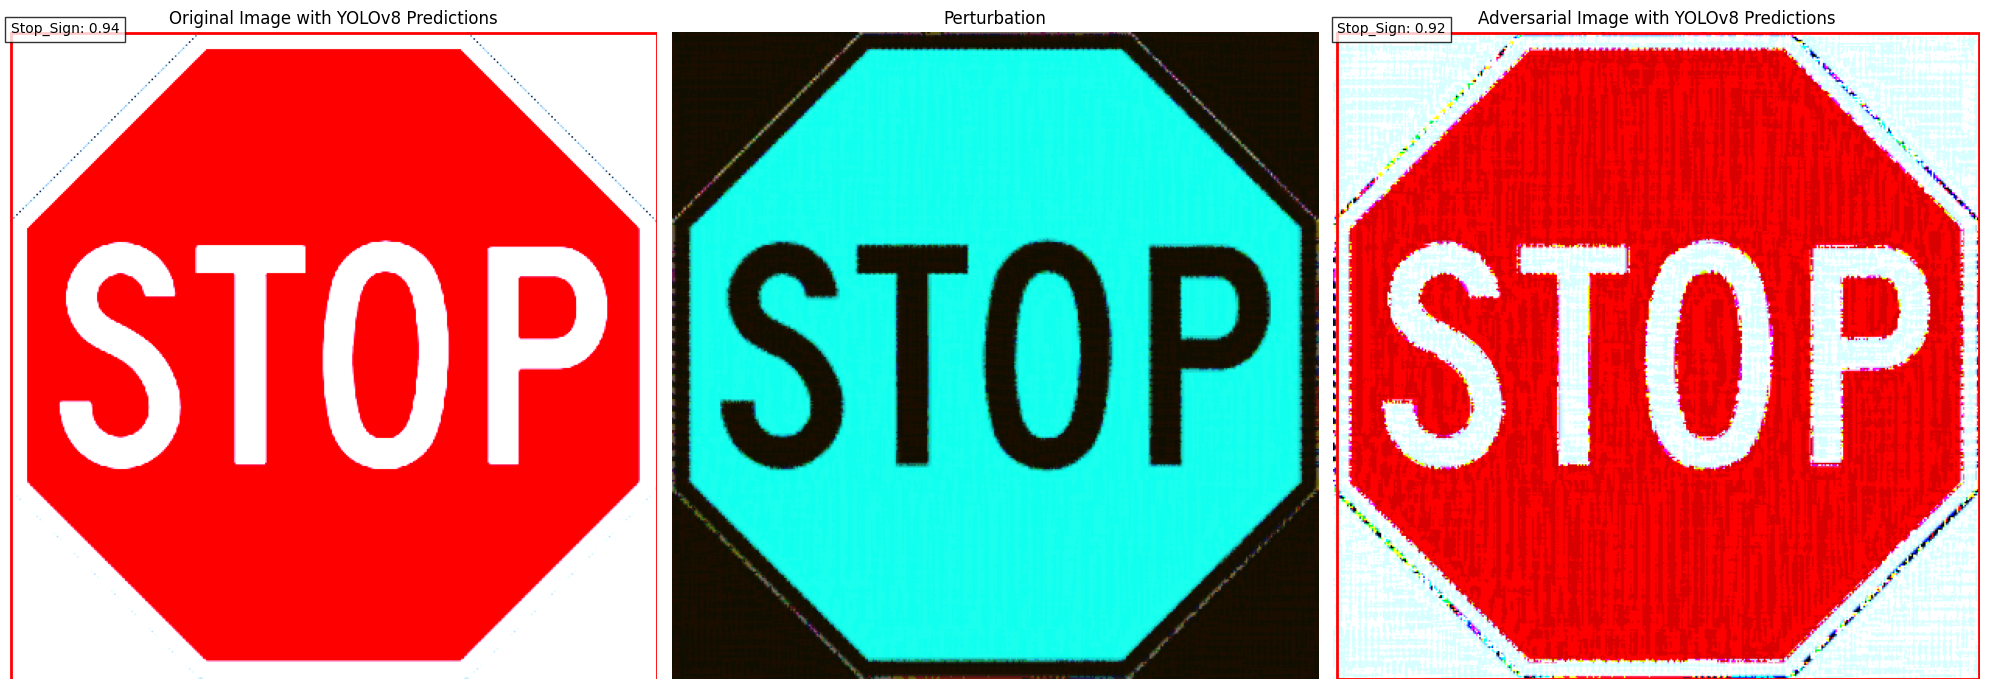

In [10]:


model = YOLOClassifier(model_path='best.pt', num_classes=29)
image = model.preprocess_image('stop.png')
YOLOm = YOLO('best.pt')

fgsm = FGSM(1.4)
label = torch.tensor([22])
perturbed_image = fgsm.attack(model , image , label)
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
boxes, scores, labels = get_yolo_output(YOLOm, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(YOLOm, perturbed_image)
# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image, YOLOm)

# Perturbation
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image,YOLOm)

plt.tight_layout()
plt.show()



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 34.2ms
Speed: 1.8ms preprocess, 34.2ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 34.3ms
Speed: 1.7ms preprocess, 34.3ms inference, 7.8ms postprocess per image at shape (1, 3, 416, 416)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


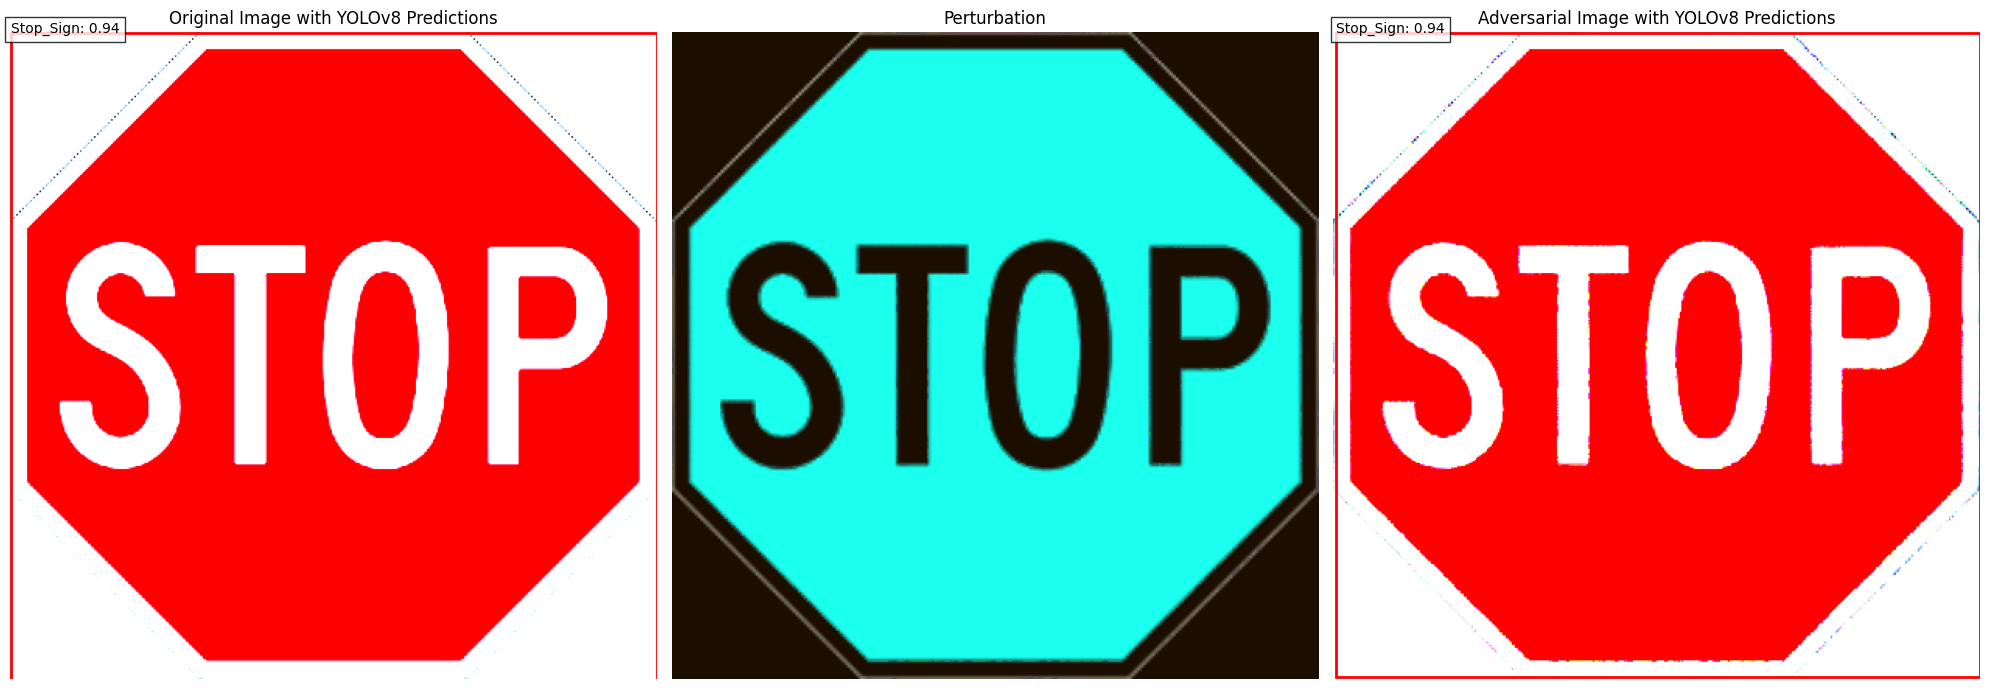

In [17]:
bim = BIM(0.5, 0.02, 100)
label = torch.tensor([22])
perturbed_image = bim.attack(model , image , label)
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
boxes, scores, labels = get_yolo_output(YOLOm, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(YOLOm, perturbed_image)
# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image, YOLOm)

# Perturbation
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image,YOLOm)

plt.tight_layout()
plt.show()


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 20.1ms
Speed: 8.0ms preprocess, 20.1ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


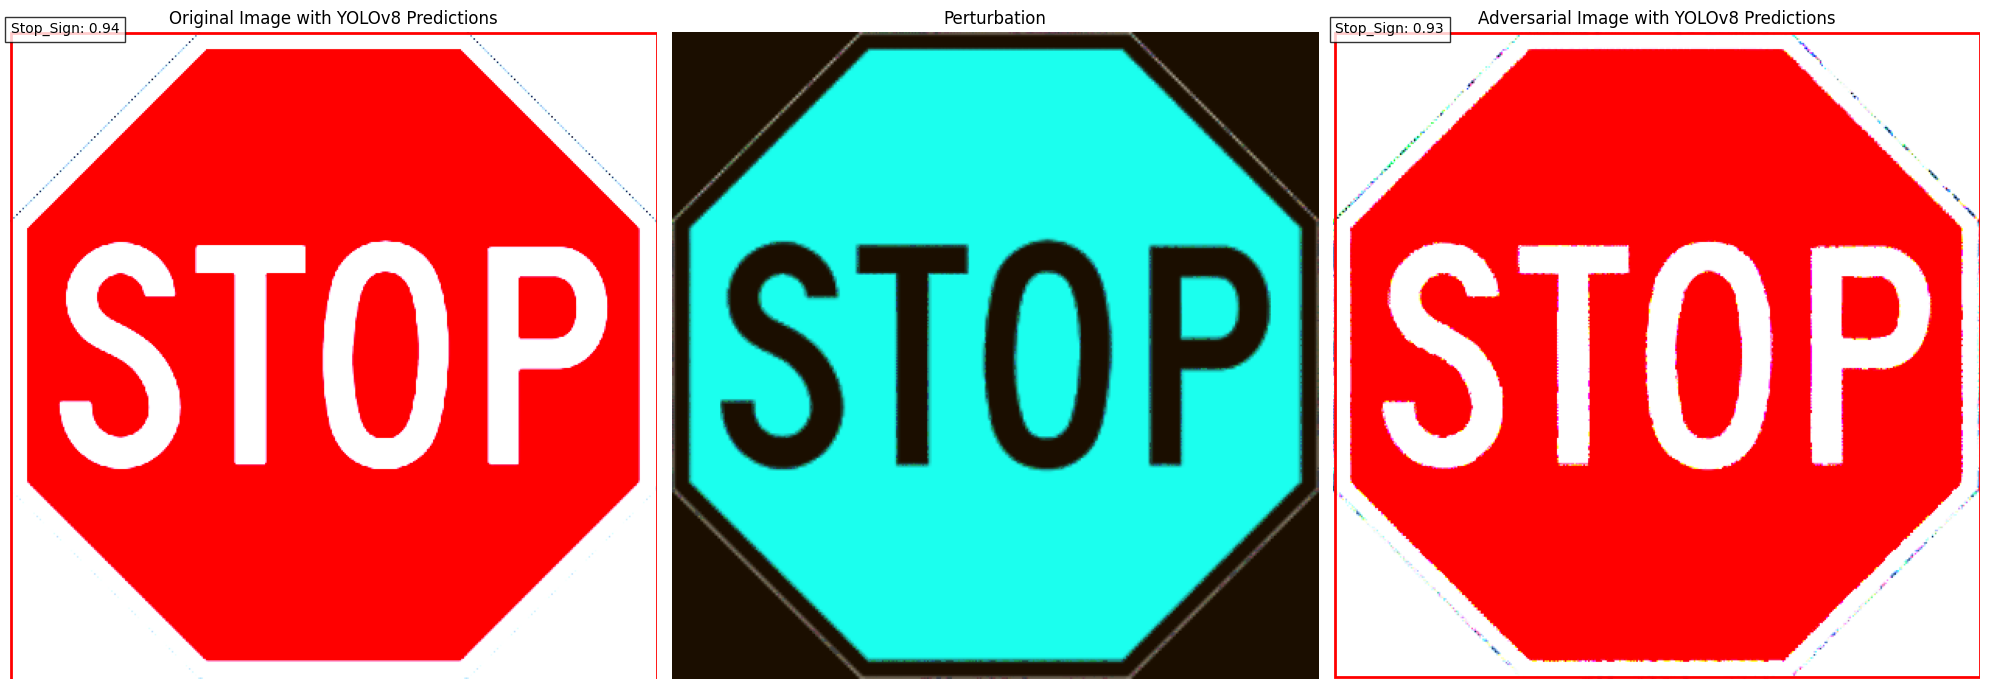

In [21]:
pgd = PGD(0.7, 0.02, 1000)
label = torch.tensor([22])
perturbed_image = pgd.attack(model , image , label)
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
boxes, scores, labels = get_yolo_output(YOLOm, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(YOLOm, perturbed_image)
# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image, YOLOm)

# Perturbation
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image,YOLOm)

plt.tight_layout()
plt.show()

In [32]:
import torch
import numpy as np
import copy

class DeepFool:
    def __init__(self, max_iter=5000, epsilon=1e-3, overshoot=0.02, num_classes=10):
        """
        DeepFool attack with overshoot and numerical stability handling.

        Args:
            max_iter (int): Maximum number of iterations.
            epsilon (float): Perturbation step size.
            overshoot (float): Overshoot factor for more robust adversarial examples.
            num_classes (int): Number of classes for classification task.
        """
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.overshoot = overshoot
        self.num_classes = num_classes

    def attack(self, model, image, label):
        """
        Generates an adversarial example using DeepFool Attack.

        Args:
            model (nn.Module): Target model to attack.
            image (torch.Tensor): Input image tensor.
            label (torch.Tensor): True label tensor for the input image.

        Returns:
            torch.Tensor: Adversarial example tensor.
        """
        model = model.classify_model
        perturbed_image = image.clone().detach()
        perturbed_image.requires_grad = True

        # Get initial class predictions
        output = model(perturbed_image)
        _, pred = torch.max(output, dim=1)
        
        if pred.item() != label.item():
            return perturbed_image  # If already misclassified, no need for perturbation

        # Initialize the perturbation and total perturbation
        input_shape = image.shape
        r_tot = torch.zeros_like(image)
        loop_i = 0

        while pred.item() == label.item() and loop_i < self.max_iter:
            # Forward pass to get the class scores
            output = model(perturbed_image)
            fs = output[0]

            # Gradients for the true class
            model.zero_grad()
            fs[label].backward(retain_graph=True)
            grad_orig = perturbed_image.grad.data.clone()

            # Initialize minimal perturbation
            perturbation = np.inf

            for k in range(1, self.num_classes):
                perturbed_image.grad.zero_()  # Zero the gradient for the next class
                
                fs[k].backward(retain_graph=True)
                grad_next = perturbed_image.grad.data.clone()

                # Compute direction for perturbation
                w_k = grad_next - grad_orig
                f_k = fs[k] - fs[label]

                pert_k = abs(f_k) / w_k.view(-1).norm()

                # Choose minimal perturbation
                if pert_k < perturbation:
                    perturbation = pert_k
                    w = w_k

            # Compute perturbation for this iteration
            r_i = perturbation * w / w.view(-1).norm()
            r_tot += r_i

            # Apply the perturbation with overshoot
            perturbed_image = image + (1 + self.overshoot) * r_tot
            perturbed_image = torch.clamp(perturbed_image, 0, 1).detach()

            perturbed_image.requires_grad = True  # Re-enable gradient computation

            # Get prediction for updated image
            output = model(perturbed_image)
            _, pred = torch.max(output, dim=1)

            loop_i += 1

        return perturbed_image



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 26.8ms
Speed: 2.9ms preprocess, 26.8ms inference, 10.0ms postprocess per image at shape (1, 3, 416, 416)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 56.5ms
Speed: 1.6ms preprocess, 56.5ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
/tmp/ipykernel_2275/3740510616.py:12: RuntimeWarning: invalid value encountered in divide
  perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


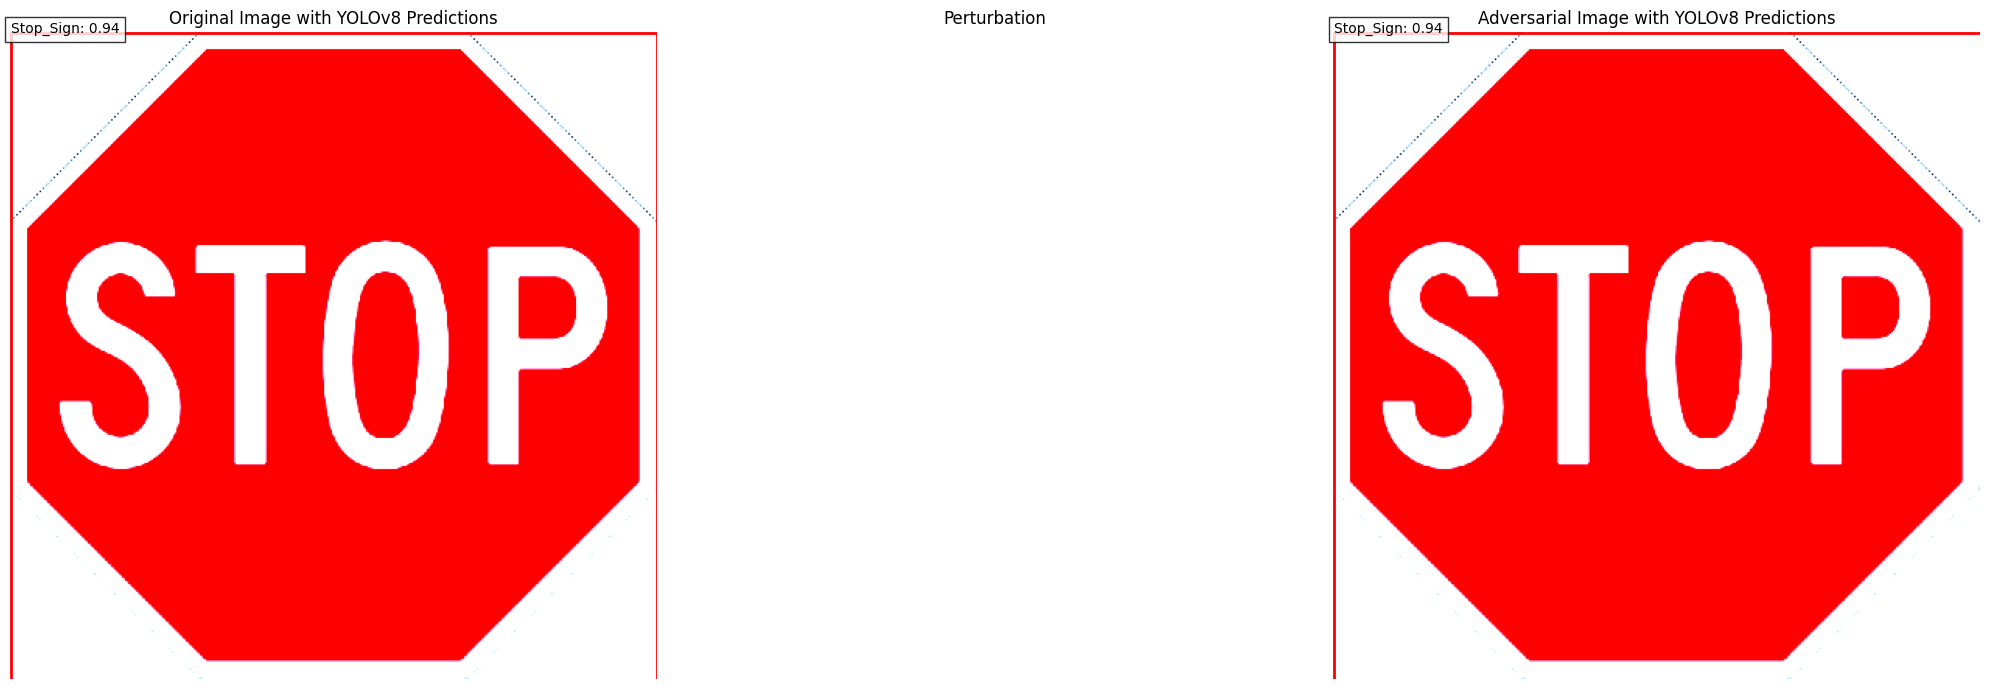

In [33]:
deepfool = DeepFool()
label = torch.tensor([22])
perturbed_image = deepfool.attack(model , image , label)
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
boxes, scores, labels = get_yolo_output(YOLOm, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(YOLOm, perturbed_image)
# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image, YOLOm)

# Perturbation
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image,YOLOm)

plt.tight_layout()
plt.show()

In [35]:
def deepfool(image, net, num_classes=29, overshoot=0.02, max_iter=10):
    net = net.classify_model
    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [46]:
r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model,max_iter=50)

/tmp/ipykernel_2275/160523420.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image[None, :],requires_grad=True)
/tmp/ipykernel_2275/160523420.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image, requires_grad=True)



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 23.9ms
Speed: 2.1ms preprocess, 23.9ms inference, 8.7ms postprocess per image at shape (1, 3, 416, 416)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.9058046340942383. Dividing input by 255.
0: 416x416 1 Stop_Sign, 28.3ms
Speed: 1.8ms preprocess, 28.3ms inference, 7.7ms postprocess per image at shape (1, 3, 416, 416)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
/tmp/ipykernel_2275/3978135293.py:18: RuntimeWarning: invalid value encountered in divide
  perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())  # Normalize to [0, 1]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


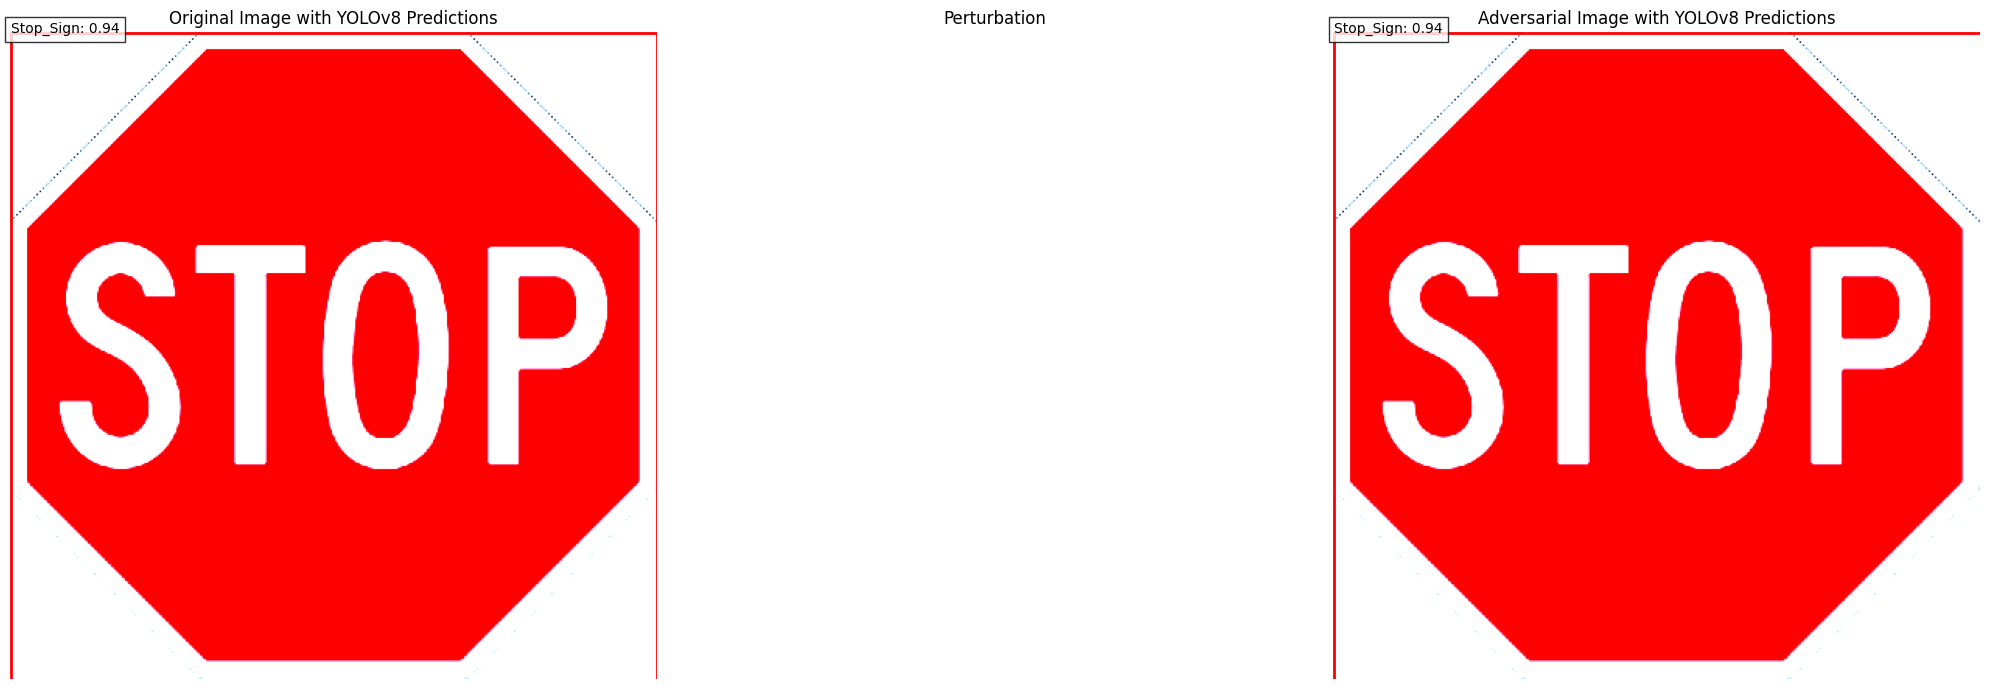

In [50]:
pert_image = pert_image.squeeze(1)
pert_image_np = pert_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

# Ensure the image is in the [0, 1] range
pert_image_np = np.clip(pert_image_np, 0, 1)
# Get YOLO predictions for both original and perturbed images
boxes, scores, labels = get_yolo_output(YOLOm, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(YOLOm, pert_image)

# Plotting setup
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# 1. Original image with YOLO predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image, YOLOm)

# 2. Perturbation (visualized as the difference between the original and perturbed image)
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())  # Normalize to [0, 1]
perturbation = np.clip(perturbation, 0, 1)

axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')  # Hide axes for clarity

# 3. Adversarial image with YOLO predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image, YOLOm)

# Tight layout for better spacing
plt.tight_layout()
plt.show()
